In [1]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_right = Image.open("1000031844.jpg")
img_left = Image.open("1000031845.jpg")

In [3]:
# Punkty
img_left_coordinates = [ 
    (814, 307), (1550, 665), (873, 786), (1380, 834), (2229, 748), (1526, 1038), 
    (2235, 1470), (965, 1574), (2076, 2304), (1420, 2679), (2061, 2723), (2188, 2708),
    (227, 1545), (262, 839), (2228, 411)
]

img_right_coordinates = [
    (2339, 399), (2992, 606), (2358, 827), (2837, 805), (3894, 565), (3079, 992), 
    (3907, 1421), (2561, 1540), (3699, 2382), (2997, 2648), (3681, 2855), (3843, 2867),
    (2024, 1516), (2041, 936), (3888, 164)
]

In [4]:
#confusion check
img_right_coordinates = np.array(img_right_coordinates)
img_left_coordinates = np.array(img_left_coordinates)

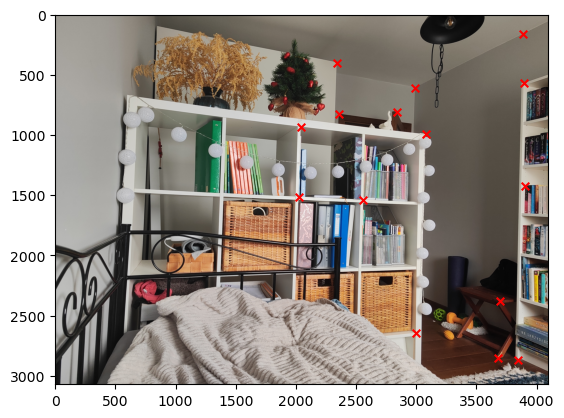

In [5]:
plt.imshow(img_right)
plt.scatter(img_right_coordinates[:,0], img_right_coordinates[:,1],marker="x", color="red", s=30); 

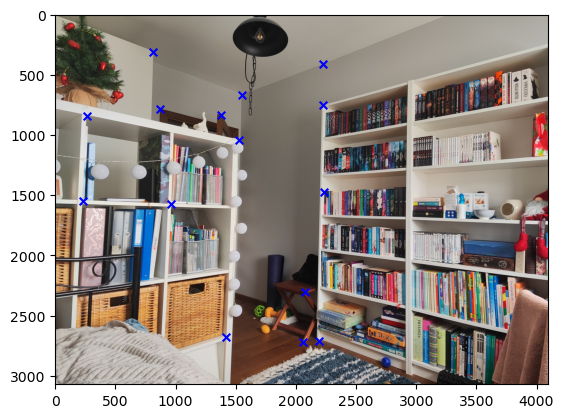

In [6]:
plt.imshow(img_left)
plt.scatter(img_left_coordinates[:,0], img_left_coordinates[:,1],marker="x", color="blue", s=30); 

coefficients to parametry homografii w kierunku: obraz źródłowy → obraz docelowy
$$ (x', y') = \left( \frac{ax + by + c}{gx + hy + 1}, \frac{dx + ey + f}{gx + hy + 1} \right) $$

In [7]:
def find_coefficients(right_coords, left_coords):
    tmp = []
    for src, tgt in zip(right_coords, left_coords):
        tmp.append([tgt[0],  tgt[1], 1,      0,             0, 0, -src[0]*tgt[0], -src[0]*tgt[1]])
        tmp.append([0,            0, 0, tgt[0],        tgt[1], 1, -src[1]*tgt[0], -src[1]*tgt[1]])
    a = np.matrix(tmp, dtype=float)
    b = np.array(right_coords).reshape(30)
    res = np.dot(np.linalg.inv(a.T * a) * a.T, b)
    return np.array(res).reshape(8)

In [8]:
coefficients = find_coefficients(img_left_coordinates, img_right_coordinates)

In [9]:
print(img_left.size)

(4096, 3072)


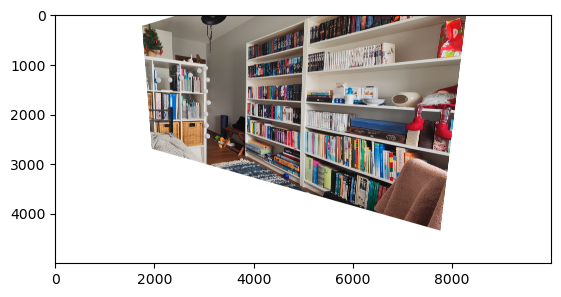

In [10]:
new_size=(10000, 5000)
width, height = new_size
plt.imshow(img_left.transform((width, height), Image.PERSPECTIVE, coefficients, fill=0, fillcolor='white'));

In [11]:
img_left.convert("RGB")
img_right.convert("RGB")

w1, h1 = (img_left.convert("RGB")).size
w2, h2 = (img_right.convert("RGB")).size

macierz homografii daje:
$$ (x, y, 1) \rightarrow (x', y', w') $$

wyjasnienie czemu macierz homografii, a nie coefficients (to tez homografia)

In [12]:
homography_matrix = np.array([
    [coefficients[0], coefficients[1], coefficients[2]],
    [coefficients[3], coefficients[4], coefficients[5]],
    [coefficients[6], coefficients[7], 1.0],], dtype=float)
homography_matrix = np.linalg.inv(homography_matrix)

In [13]:
#liczymy nowy rozmiar plotna

corners_left = np.array([[0, 0, 1], [w2, 0, 1], [w2, h2, 1], [0, h2, 1]]).T  #wgl skad te wspolrzedne rogow obrazu?
corners_trans_left = (homography_matrix @ corners_left)
corners_trans_left = corners_trans_left / corners_trans_left[2]

all_x = np.concatenate((corners_trans_left[0], [0, w1]))
all_y = np.concatenate((corners_trans_left[1], [0, h1]))

shift_x = -np.min(all_x)
shift_y = -np.min(all_y)

new_w = int(np.ceil(np.max(all_x) - np.min(all_x)))
new_h = int(np.ceil(np.max(all_y) - np.min(all_y)))

macierz translacji daje:
$$ (x, y) \rightarrow (x + shift_x, y + shift_y) $$

In [14]:
# co tu robimy dokladnie? xd
translation_matrix = np.array([[1, 0, shift_x], [0, 1, shift_y], [0, 0, 1]], dtype=float)

$$ p_{src} \xrightarrow{H} p_{base} \xrightarrow{T} p_{canvas} $$

In [15]:
final_matrix = translation_matrix @ homography_matrix
final_matrix_inv = np.linalg.inv(final_matrix)
PIL_friendly_matrix = final_matrix_inv / final_matrix_inv[2, 2]


coeffs to parametry homografii w kierunku: piksel WYJŚCIOWY → piksel ŹRÓDŁOWY

In [16]:
coeffs = PIL_friendly_matrix.flatten()[:8]

In [17]:
# tworzymy pusta warstwe i wklejamy obraz panoramy

layer1 = Image.new("RGBA", (new_w, new_h), (0, 0, 0, 0))
layer1.paste(img_right.convert("RGBA"), (int(shift_x), int(shift_y)))

layer2 = img_left.transform((new_w, new_h), Image.PERSPECTIVE, coeffs, Image.BICUBIC).convert("RGBA")


In [18]:
arr1_u8 = np.array(layer1, dtype=np.uint8)  # (H,W,4)
arr2_u8 = np.array(layer2, dtype=np.uint8)

a1 = arr1_u8[:, :, 3] > 0
a2 = arr2_u8[:, :, 3] > 0
overlap = a1 & a2

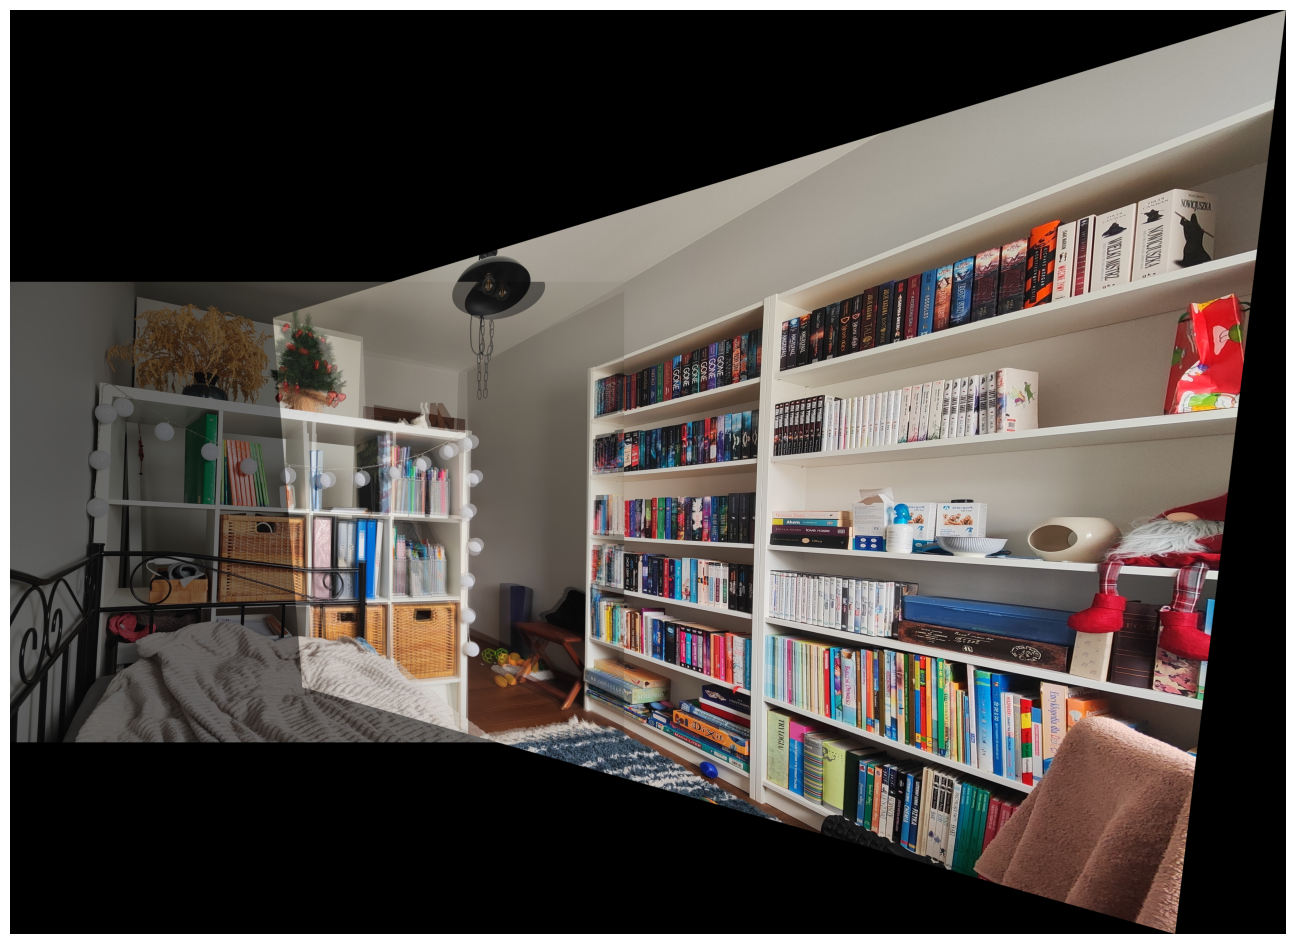

In [19]:

out = np.zeros_like(arr1_u8, dtype=np.uint8)

m = a1 & (~overlap)
out[m] = arr1_u8[m]

m = a2 & (~overlap)
out[m] = arr2_u8[m]

if np.any(overlap):
    rgb1 = arr1_u8[:, :, :3].astype(np.uint16)
    rgb2 = arr2_u8[:, :, :3].astype(np.uint16)
    avg = ((rgb1 + rgb2) >> 1).astype(np.uint8)   # (a+b)//2
    out[overlap, :3] = avg[overlap]
    out[overlap, 3] = 255

panorama_check = Image.fromarray(out, mode="RGBA")

plt.figure(figsize=(18, 12))
plt.imshow(panorama_check)
plt.axis('off')
plt.show()


>>> KROK 3: Przycinanie (wzorcowe) — RAM-friendly...
Użyty zakres Y: 1815:4883 (Wysokość paska: 3068)
Znaleziono krawędzie -> Góra: 8291, Dół: 7923
Finalne cięcie X: 7924


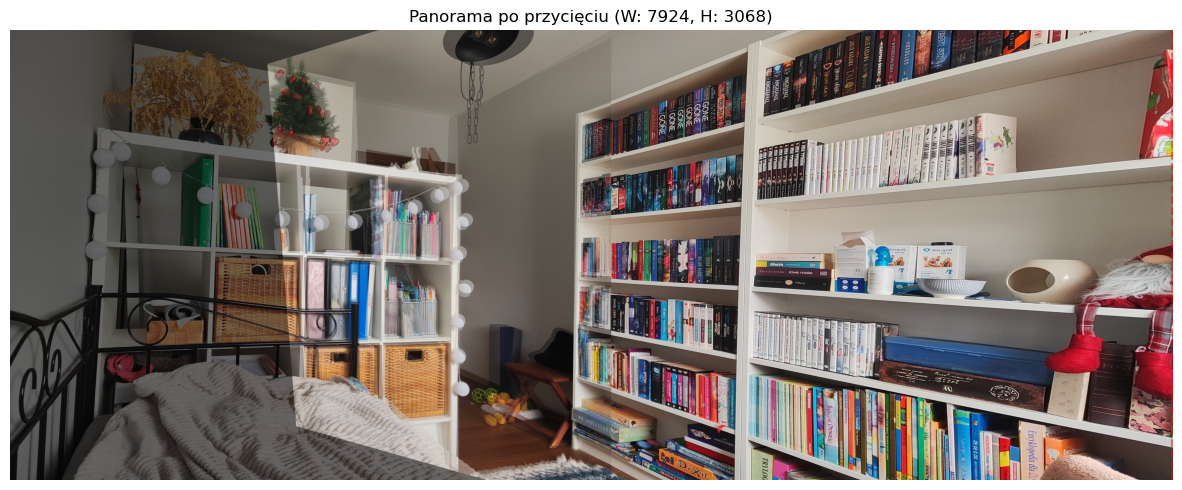

In [20]:
print(">>> KROK 3: Przycinanie (wzorcowe) — RAM-friendly...")
arr1_u8 = np.array(layer1, dtype=np.uint8)  # (H,W,4)
arr2_u8 = np.array(layer2, dtype=np.uint8)

# arr1_u8, arr2_u8: uint8 RGBA z komórki 13
h_full, w_full, _ = arr1_u8.shape

# Y-range jak we wzorcu (z bezpiecznikami)
y_s_calc = int(shift_y) + 2
y_e_calc = int(shift_y + h1) - 2

if y_s_calc >= h_full or y_e_calc <= 0 or y_s_calc < 0:
    print(f"! OSTRZEŻENIE: shift_y ({shift_y}) poza zakresem. Ustawiam start na 0.")
    y_start = 2
    y_end = min(h_full, int(h1) - 2)
else:
    y_start = y_s_calc
    y_end = min(h_full, y_e_calc)

if y_end <= y_start:
    print("! BŁĄD ZAKRESU: y_end <= y_start. Reset do pełnej wysokości.")
    y_start = 0
    y_end = h_full

print(f"Użyty zakres Y: {y_start}:{y_end} (Wysokość paska: {y_end - y_start})")

# Detekcja tła (odpowiednik brightness<0.06 na float)
# float: sum(RGB) < 0.06  (gdzie RGB w [0,1], suma w [0,3])
# uint8: sum(RGB) < 0.06 * 3 * 255 = 45.9 ~ 46 (gdzie suma w [0,765])
strip1 = arr1_u8[y_start:y_end, :]
strip2 = arr2_u8[y_start:y_end, :]
strip_combined = np.maximum(strip1, strip2)  # uint8

pixel_brightness = (
    strip_combined[:, :, 0].astype(np.uint16) +
    strip_combined[:, :, 1].astype(np.uint16) +
    strip_combined[:, :, 2].astype(np.uint16)
)
is_background = pixel_brightness < 46

def find_edge_from_right(row_bool_array):
    width = len(row_bool_array)
    for x in range(width - 1, -1, -1):
        if not row_bool_array[x]:
            return x
    return 0

if is_background.shape[0] > 0:
    top_edge_x = find_edge_from_right(is_background[0, :])
    bottom_edge_x = find_edge_from_right(is_background[-1, :])
    final_cut_x = min(top_edge_x, bottom_edge_x)
    final_cut_x = min(final_cut_x + 1, w_full)
else:
    top_edge_x, bottom_edge_x = w_full, w_full
    final_cut_x = w_full

print(f"Znaleziono krawędzie -> Góra: {top_edge_x}, Dół: {bottom_edge_x}")
print(f"Finalne cięcie X: {final_cut_x}")

# Crop na uint8 (to jest klucz do RAM)
arr1_u8 = arr1_u8[y_start:y_end, 0:final_cut_x].copy()
arr2_u8 = arr2_u8[y_start:y_end, 0:final_cut_x].copy()

# Sprzątanie dużych tymczasowych rzeczy
del strip1, strip2, strip_combined, pixel_brightness, is_background


# Podgląd po przycięciu (identyczna logika jak we wzorcu)
a1 = arr1_u8[:, :, 3] > 0
a2 = arr2_u8[:, :, 3] > 0
ov = a1 & a2

preview_u8 = np.zeros_like(arr1_u8, dtype=np.uint8)
preview_u8[a1] = arr1_u8[a1]
preview_u8[a2 & ~ov] = arr2_u8[a2 & ~ov]

if np.any(ov):
    rgb1 = arr1_u8[:, :, :3].astype(np.uint16)
    rgb2 = arr2_u8[:, :, :3].astype(np.uint16)
    avg = ((rgb1 + rgb2) >> 1).astype(np.uint8)  # (u1+u2)//2
    preview_u8[ov, :3] = avg[ov]
    preview_u8[ov, 3] = 255

final_panorama_view = Image.fromarray(preview_u8, mode="RGBA")

h_fin, w_fin, _ = preview_u8.shape
plt.figure(figsize=(15, 8))
plt.imshow(final_panorama_view)
plt.title(f"Panorama po przycięciu (W: {w_fin}, H: {h_fin})")
plt.axvline(x=w_fin - 2, color='red', linestyle='--', alpha=0.5)
plt.axis('off')
plt.show()

# Przygotuj float 0..1 dla kroku 4 (dopiero po cropie!)
arr1 = arr1_u8.astype(np.float32) / 255.0
arr2 = arr2_u8.astype(np.float32) / 255.0

# Możesz zwolnić uint8, żeby jeszcze oszczędzić RAM



>>> 7. ROZPOCZYNAM BLENDING (Gamma 30)...


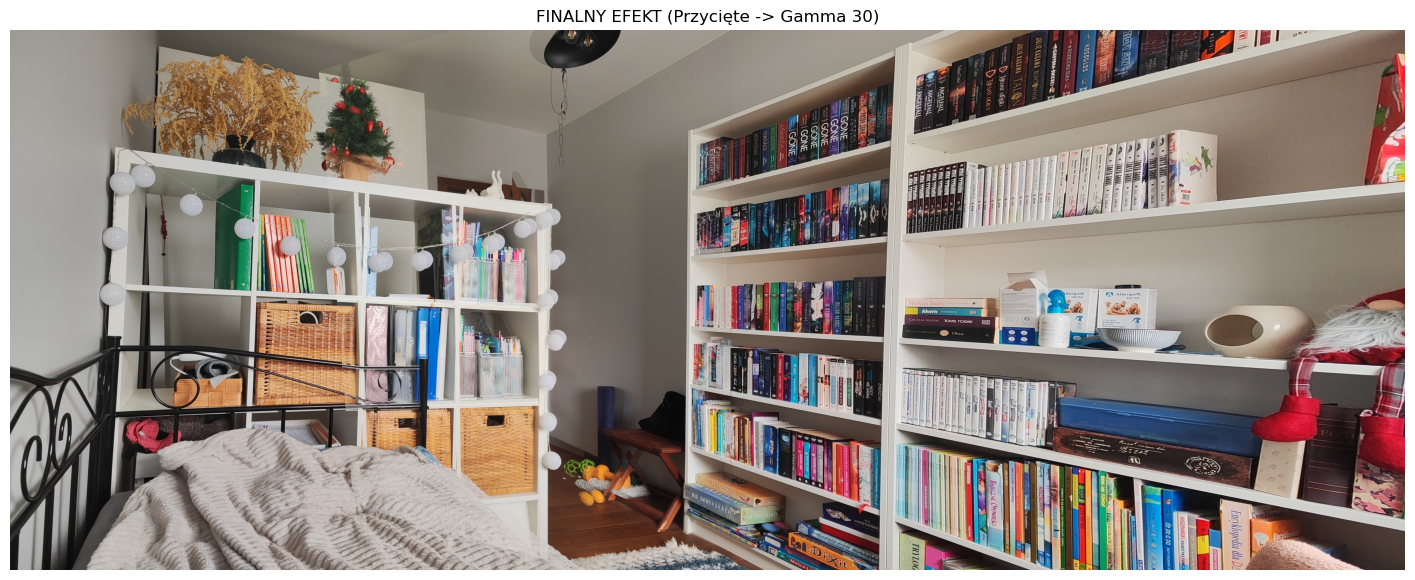

In [21]:
# --- KROK 7: BLENDING FINALNY (Gamma 30) ---

print(">>> 7. ROZPOCZYNAM BLENDING (Gamma 30)...")

# 1. PARAMETRY
GAMMA_BLENDING = 30
JASNOSC = 1.0
KOREKTA_RGB = (1.0, 1.0, 1.0) 

# Pobieramy wymiary z przyciętych już obrazków
nh_crop, nw_crop, _ = arr1.shape

# 2. Korekta kolorów (Neutralna)
arr2[:, :, 0] *= (JASNOSC * KOREKTA_RGB[0])
arr2[:, :, 1] *= (JASNOSC * KOREKTA_RGB[1])
arr2[:, :, 2] *= (JASNOSC * KOREKTA_RGB[2])
arr2 = np.clip(arr2, 0, 1.0)

# 3. Maski i Overlap
mask1 = arr1[:,:,3] > 0
mask2 = arr2[:,:,3] > 0
overlap = mask1 & mask2
final = np.zeros_like(arr1)

if np.any(overlap):
    # Znajdowanie granic nakładania się
    idx = np.where(np.any(overlap, axis=0))[0]
    mn, mx = idx[0], idx[-1]
    
    # Tworzenie gradientu (przejścia)
    grad = np.linspace(0, 1, mx-mn)
    alpha = np.zeros((nh_crop, nw_crop), dtype=np.float32)
    alpha[:, mn:mx] = np.tile(grad, (nh_crop, 1))
    alpha_rgb = np.dstack([alpha]*3)
    
    # Kopiowanie stref bez nakładania
    final[mask1 & ~overlap] = arr1[mask1 & ~overlap]
    final[mask2 & ~overlap] = arr2[mask2 & ~overlap]
    
    # --- MATEMATYKA GAMMA 30 ---
    # Podnosimy do potęgi 30 (to usuwa cienie/winietę)
    p1_pow = np.power(arr1[:,:,:3], GAMMA_BLENDING)
    p2_pow = np.power(arr2[:,:,:3], GAMMA_BLENDING)
    
    # Czyścimy oryginały, żeby zwolnić RAM przed sumowaniem
    del arr1, arr2
    
    w1 = 1.0 - alpha_rgb
    w2 = alpha_rgb
    
    # Mieszamy energię i pierwiastkujemy
    blend = np.power(p1_pow * w1 + p2_pow * w2, 1.0 / GAMMA_BLENDING)
    
    # Wklejamy wynik w strefę overlap
    ov3 = np.dstack([overlap]*3)
    np.copyto(final[:,:,:3], blend, where=ov3)
    final[:,:,3] = (mask1 | mask2).astype(np.float32)
else:
    # Jeśli się nie nakładają (mało prawdopodobne)
    final = arr1 + arr2

# 4. WYŚWIETLANIE WYNIKU
final_panorama = Image.fromarray((final*255).astype(np.uint8))

plt.figure(figsize=(18, 12))
plt.imshow(final_panorama)
plt.title(f"FINALNY EFEKT (Przycięte -> Gamma {GAMMA_BLENDING})")
plt.axis('off')
plt.show()